In [130]:
import numpy as np
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt
import matplotlib; 
from scipy.special import comb
plt.rcParams['figure.figsize'] = [10, 5];

## Function interpolation using polynomials

We will first present some examples of function interpolation using polynomials of degree <=n. We implement it in multiple ways: 

(1) Using the Vandermonde matrix (with the standard monomial basis {1,x,x^2,...,x^n}). This is a really bad idea (unstable). 
(2) Using the Lagrange polynomial basis; the interpolation problem (finding coefficients) becomes trivial. The main source of computation is evaluating the polynomial basis. 
(3) Using the Newton polynomial basis; the interpolation problem is not trivial but we have a formula in terms of divided differences. Polynomial evaluation can be done quickly using Horner's rule. 
(4) We implement Lagrange in a more efficient and stable manner using barycentric formulas. 

We also discuss that, for equispaced interpolation points, the error is not uniform and may suffer the Runge phenomenon. We see Chebyshev points (which accumulate at interval boundaries) solve both of these issues. 

In [131]:
def f1(x): 
    return np.sinc(3*x); 

In [132]:
def poly_interp(f,n,y):
    # polynomial interpolation of function f on n+1 equispaced points on interval [-1,1].
    # output g is the interpolant evaluated at target points y.  
    xi = np.linspace(-1,1,n+1);
    fi = f(xi); #evaluate function at interpolation points 
    
    # Create Vandermonde matrix
    V = np.zeros((n+1,n+1));
    for i in range(n+1):
        V[:,i] = xi**i; 
    
    # Solve for polynomial coefficients 
    c = np.linalg.solve(V,fi);
    c = c[::-1];
    g = np.polyval(c,y); 
    return g;

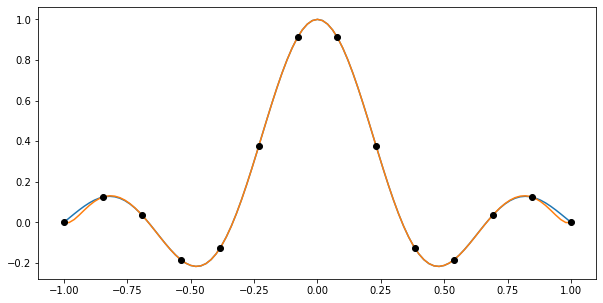

In [133]:
y = np.linspace(-0.999,0.999,101);
n=13; 
xi = np.linspace(-1,1,n+1); 
g1 = poly_interp(f1,n,y);
plt.plot(y,f1(y))
plt.plot(y,g1); 
plt.plot(xi,f1(xi),'ok')

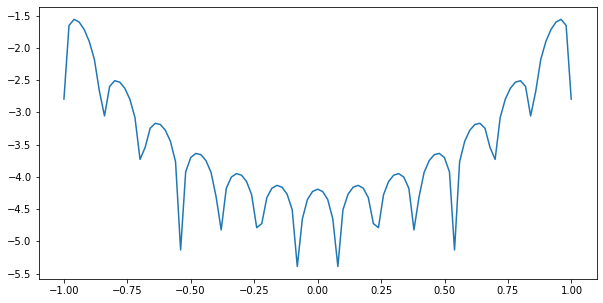

In [134]:
plt.plot(y,np.log10(np.abs(f1(y)-g1)));

In [135]:
def poly_interp_logerror(f,nn):
    y = np.linspace(-0.999,0.999,100);
    for n in nn:
        g1 = poly_interp(f,n,y);
        plt.plot(y,np.log10(np.abs(f(y)-g1)+1e-16),'-.',label='n ='+str(n));
    
    plt.legend(bbox_to_anchor=(1.1, 1.05)); 
    return; 

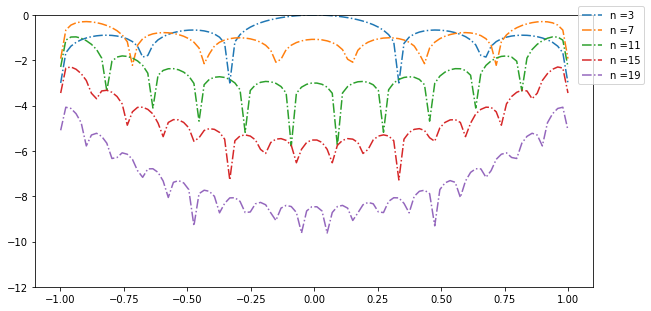

In [136]:
nn =np.arange(3,20,4);
poly_interp_logerror(f1,nn);
plt.ylim([-12,0]);

### The Vandermonde matrix is terrible

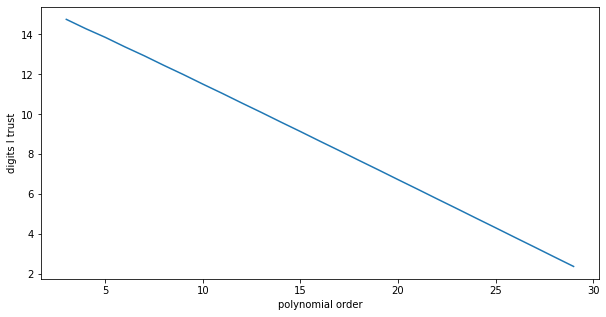

In [137]:
nM = 30; 
cV = np.zeros(nM-3);
for n in np.arange(3,nM):
    x = np.linspace(-1,1,n+1); 
    V = np.vander(x);
    cV[n-3] = np.linalg.cond(V); 

plt.plot(np.arange(3,nM),np.log10(2**(52))-np.log10(cV)); 
plt.xlabel('polynomial order');
plt.ylabel('digits I trust');

## Lagrange Interpolation 

In [138]:
def plot_lagrangebasis(n):
    xi=np.linspace(-1,1,n+1);
    y=np.linspace(-1,1,100); 
    Im=np.eye(n+1); 
    for i in np.arange(n+1):
        Li = lagrange(xi,Im[i]);
        plt.plot(y,Li(y)); 
        plt.plot(xi,Li(xi),'ok');
    return; 

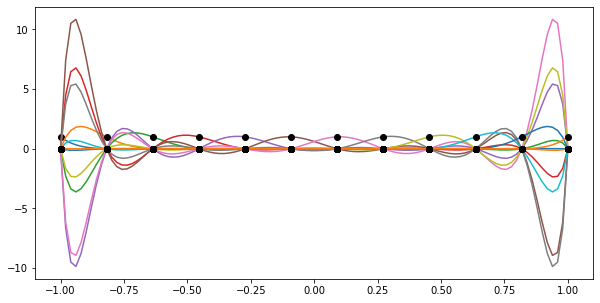

In [139]:
plot_lagrangebasis(11); 

In [140]:
def lagrange_interp_logerror(f,nn):
    y = np.linspace(-0.999,0.999,100);
    for n in nn:
        xi = np.linspace(-1,1,n+1);
        fi = f(xi); 
        g = lagrange(xi,fi);
        plt.plot(y,np.log10(np.abs(f(y)-g(y))+1e-16),'-.',label='n ='+str(n));
    
    plt.legend(bbox_to_anchor=(1.1, 1.05));
    return; 

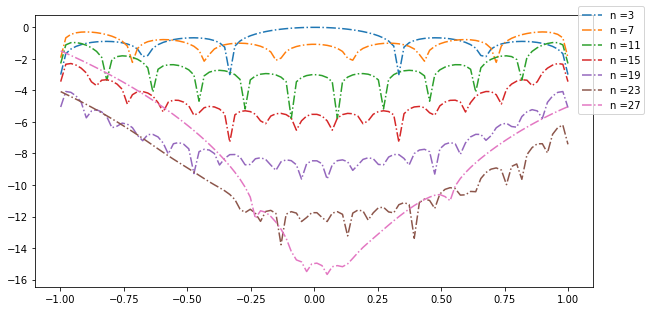

In [141]:
nn = np.arange(3,30,4);
lagrange_interp_logerror(f1,nn);

## Newton interpolation

In [142]:
def plot_newtonbasis(n):
    xi=np.linspace(-1,1,n+1);
    y=np.linspace(-1,1,100); 
    PN=np.ones(len(y));  
    plt.plot(y,PN); 
    plt.plot(xi,np.zeros(n+1),'ok');
    
    for i in np.arange(1,n+1):
        Mi=(y-xi[i-1]);
        Pi=PN[i-1]*Mi; 
        PN=np.vstack((PN,Pi));
        plt.plot(y,Pi); 
    return; 

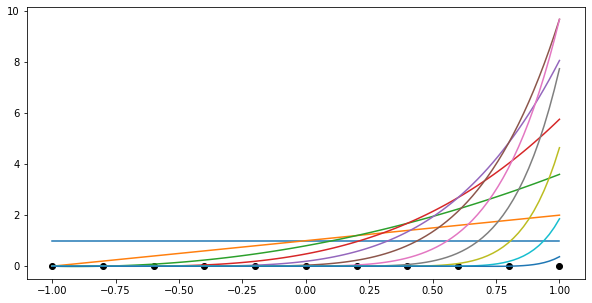

In [143]:
plot_newtonbasis(10);

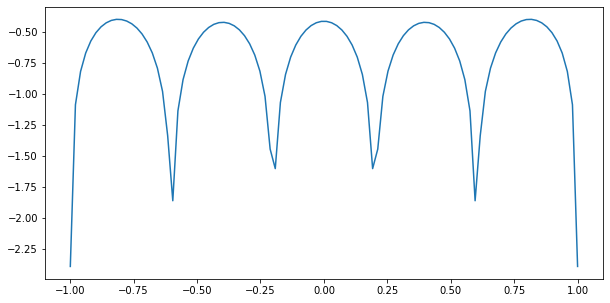

In [144]:
def newton_interp(f,n,y):
    xi=np.linspace(-1,1,n+1); #equispaced pts
    fi=f(xi);                 #function values
    
    D = np.zeros((n+1,n+1)); #matrix of divided differences
    D[0]=fi; 
    for i in np.arange(1,n+1):
        # Compute divided differences at row i using row i-1. 
        D[i,0:n+1-i]=(D[i-1,1:n+2-i] - D[i-1,0:n+1-i])/(xi[i:n+1] - xi[0:n+1-i]);
    
    cN = D[:,0]; #Interpolation coefficients are stored on the first column of D. 
    
    # Evaluation (Horner's rule)
    g = cN[n]*np.ones(len(y)); #constant term
    for i in np.arange(n-1,-1,-1):
        g = g*(y-xi[i]) + cN[i]; 
    
    return (g,cN); 

y=np.linspace(-0.999,0.999,100);
(g,cN) = newton_interp(f1,5,y); 
plt.plot(y,np.log10(np.abs(f1(y)-g))); 

In [145]:
def newton_interp_logerror(f,nn):
    y = np.linspace(-0.999,0.999,100);
    for n in nn: 
        (g,c) = newton_interp(f,n,y); 
        plt.plot(y,np.log10(np.abs(f(y)-g)+1e-16),'-.',label='n ='+str(n));
    
    plt.legend(bbox_to_anchor=(1.1, 1.05));
    return; 

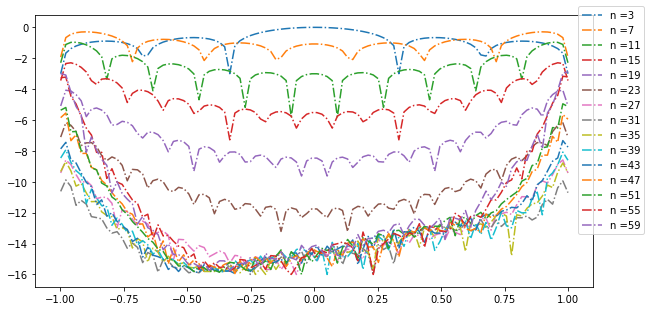

In [146]:
nn = np.arange(3,60,4);
newton_interp_logerror(f1,nn); 

## Equispaced vs Chebyshev points: the Runge phenomenon

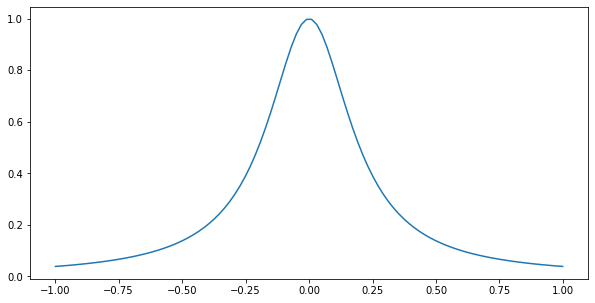

In [147]:
def f2(x):
    return 1/(1+25*x**2); 
y = np.linspace(-0.999,0.999,100); 
plt.plot(y,f2(y)); 

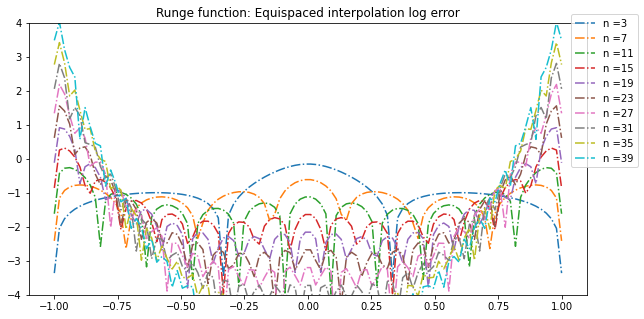

In [185]:
nn = np.arange(3,40,4);
newton_interp_logerror(f2,nn);
plt.ylim([-4,4]);
plt.title('Runge function: Equispaced interpolation log error');

In [149]:
def chebpts(n):
    theta = np.linspace(0,np.pi,n+1);
    return -np.cos(theta);

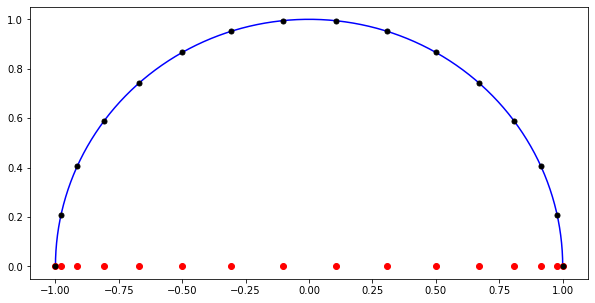

In [188]:
n=15; 
xc = chebpts(n); 
theta=np.linspace(0,np.pi,n+1); 
th = np.linspace(0,np.pi,100);
plt.plot(np.cos(th),np.sin(th),'b');
plt.plot(xc,np.zeros(len(xc)),'or',markersize=6);
plt.plot(np.cos(theta),np.sin(theta),'.k',markersize=10);

In [152]:
def plot_cheblagrangebasis(n):
    xi=chebpts(n);
    y=np.linspace(-1,1,100); 
    Im=np.eye(n+1); 
    for i in np.arange(n+1):
        Li = lagrange(xi,Im[i]);
        plt.plot(y,Li(y)); 
        plt.plot(xi,Li(xi),'ok');
    return; 

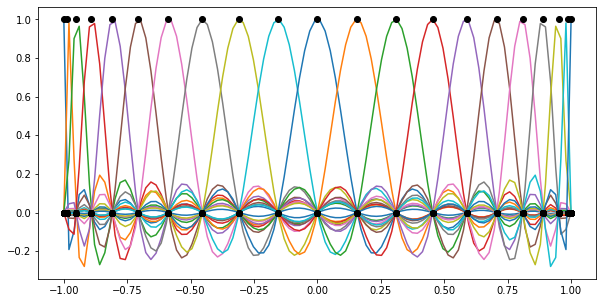

In [153]:
plot_cheblagrangebasis(20);

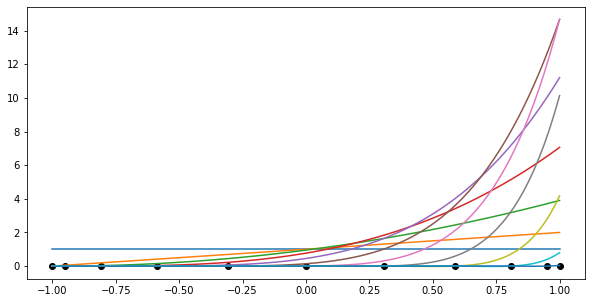

In [154]:
def plot_chebnewtonbasis(n):
    xi=chebpts(n);
    y=np.linspace(-1,1,100); 
    PN=np.ones(len(y));  
    plt.plot(y,PN); 
    plt.plot(xi,np.zeros(n+1),'ok');
    
    for i in np.arange(1,n+1):
        Mi=(y-xi[i-1]);
        Pi=PN[i-1]*Mi; 
        PN=np.vstack((PN,Pi));
        plt.plot(y,Pi); 
    return; 

plot_chebnewtonbasis(10);

In [155]:
def newton_interp_cheb(f,n,y):
    xi=chebpts(n); #Chebyshev pts
    fi=f(xi);                 #function values
    
    D = np.zeros((n+1,n+1)); #matrix of divided differences
    D[0]=fi; 
    for i in np.arange(1,n+1):
        # Compute divided differences at row i using row i-1. 
        D[i,0:n+1-i]=(D[i-1,1:n+2-i] - D[i-1,0:n+1-i])/(xi[i:n+1] - xi[0:n+1-i]);
    
    cN = D[:,0]; #Interpolation coefficients are stored on the first column of D. 
    
    # Evaluation (Horner's rule)
    g = cN[n]*np.ones(len(y)); #constant term
    for i in np.arange(n-1,-1,-1):
        g = g*(y-xi[i]) + cN[i]; 
    
    return (g,cN); 


def newton_chebint_logerror(f,nn):
    y = np.linspace(-0.999,0.999,100);
    for n in nn: 
        (g,c) = newton_interp_cheb(f,n,y); 
        plt.plot(y,np.log10(np.abs(f(y)-g)+1e-16),'-.',label='n ='+str(n));
    
    plt.legend(bbox_to_anchor=(1.1, 1.05));
    return; 

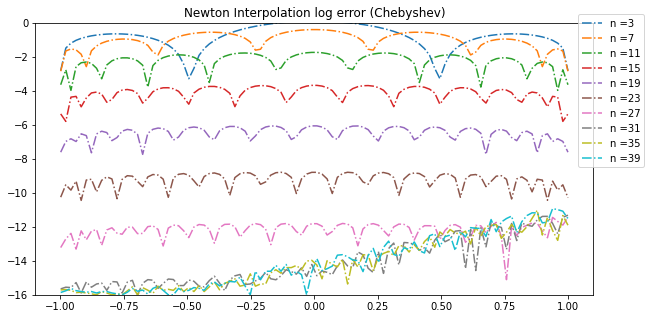

In [182]:
nn = np.arange(3,41,4);
newton_chebint_logerror(f1,nn);
plt.ylim([-16,0]);
plt.title("Newton Interpolation log error (Chebyshev)");

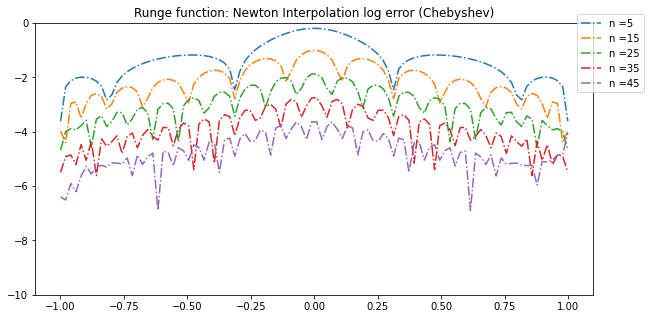

In [181]:
nn = np.arange(5,51,10);
newton_chebint_logerror(f2,nn);
plt.ylim([-10,0]);
plt.title("Runge function: Newton Interpolation log error (Chebyshev)");

## Improving Lagrange: barycentric formulas 

In [165]:
n=5;
xi = np.linspace(-1,1,n+1);
xj = np.linspace(-1,1,n+1); xj=xj[:,np.newaxis];

dij = (xi-xj) + np.eye(n+1); 
#print(dij);
w = 1/np.prod(dij,axis=0);
print(w)

cmb=np.zeros(n+1); 
for i in np.arange(n+1):
    cmb[i]=comb(n,i); 

h=2/n; 
print(np.math.factorial(n)*h**n)
print(1/w[0])
print (w/cmb)
    
xi2 = chebpts(n);
xj2 = chebpts(n); xj2=xj2[:,np.newaxis];

dij2 = (xi2-xj2) + np.eye(n+1); 
#print(dij2);
w2 = 1/np.prod(dij2,axis=0);
print(w2)
print((n/2**(n-1))*w2)

[-0.81380208  4.06901042 -8.13802083  8.13802083 -4.06901042  0.81380208]
1.2288000000000003
-1.2288000000000006
[-0.81380208  0.81380208 -0.81380208  0.81380208 -0.81380208  0.81380208]
[-1.6  3.2 -3.2  3.2 -3.2  1.6]
[-0.5  1.  -1.   1.  -1.   0.5]


In [166]:
def barylagrange_weights(n,xi,type):
    ################################################
    # Barycentric weight calculation
    if type=='cheb':
        # Chebyshev weights are 1/2 or 1 (alternating sign)
        w = np.ones(n+1); 
        w[(n+1)%2::2]=-1; 
        w[0]=w[0]*0.5; w[-1]=w[-1]*0.5;
    elif type=='equi':
        # Equispaced weights are (n choose j) (alternating sign)
        w = np.zeros(n+1); 
        for i in np.arange(n+1):
            w[i]=((-1)**(i))*comb(n,i);
    else:
        # General formula
        dij = (xi-xi[:,np.newaxis]) + np.eye(n+1); 
        w = 1/np.prod(dij,axis=0);
    #################################################
    return w; 

def barylagrange_interp(f,y,xi,type='cheb'):
    n = len(xi)-1; 
    w = barylagrange_weights(n,xi,type);
        
    g = np.zeros(len(y));
    den = np.zeros(len(y)); 

    # We apply the 2nd baycentric formula to compute the interpolant
    for j in np.arange(n+1):
        g = g + (w[j]*f(xi[j]))/(y-xi[j]);
        den = den + w[j]/(y-xi[j]);
    
    g = g/den; 
    return g; 

In [167]:
xi = np.array([-2,-1,0,1,2,3]);
w = barylagrange_weights(5,xi,'equi');
w2 = barylagrange_weights(5,xi,'gen');
print(w)
print(w2*(-120))

[  1.  -5.  10. -10.   5.  -1.]
[  1.  -5.  10. -10.   5.  -1.]


In [168]:
def barylagrange_cinterp_logerror(f,nn):
    y = np.linspace(-0.999,0.999,100);
    for n in nn:
        xi = chebpts(n);
        fi = f(xi); 
        gy = barylagrange_interp(f,y,xi,'cheb');
        plt.plot(y,np.log10(np.abs(f(y)-gy+1e-16)),'-.',label='n ='+str(n));
    
    plt.legend(bbox_to_anchor=(1.1, 1.05));
    return; 

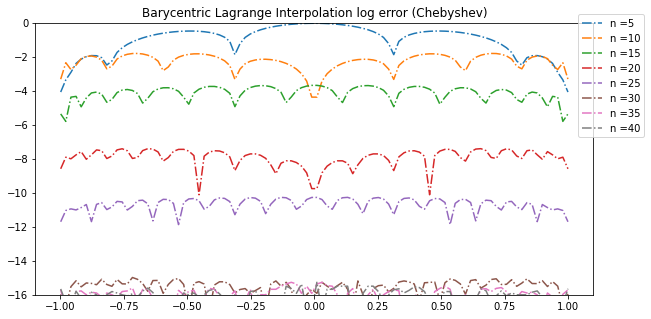

In [179]:
nn = np.arange(5,41,5);
barylagrange_cinterp_logerror(f1,nn);
plt.ylim([-16,0]);
plt.title("Barycentric Lagrange Interpolation log error (Chebyshev)");

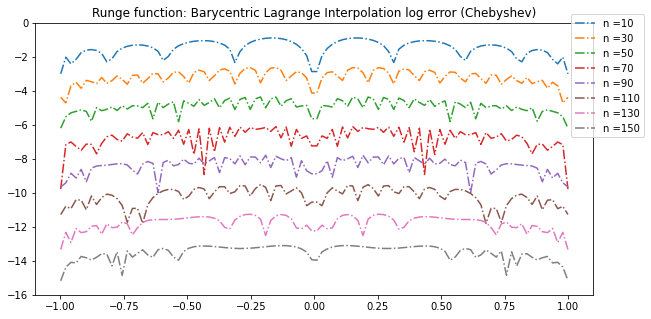

In [190]:
nn = np.arange(10,151,20);
barylagrange_cinterp_logerror(f2,nn);
plt.ylim([-16,0]);
plt.title("Runge function: Barycentric Lagrange Interpolation log error (Chebyshev)");

In [117]:
def barylagrange_interp_logerror(f,nn):
    y = np.linspace(-0.999,0.999,100);
    for n in nn:
        xi = np.linspace(-1,1,n+1);
        fi = f(xi); 
        gy = barylagrange_interp(f,y,xi,'equi');
        plt.plot(y,np.log10(np.abs(f(y)-gy+1e-16)),'-.',label='n ='+str(n));
    
    plt.legend(bbox_to_anchor=(1.1, 1.05));
    return;

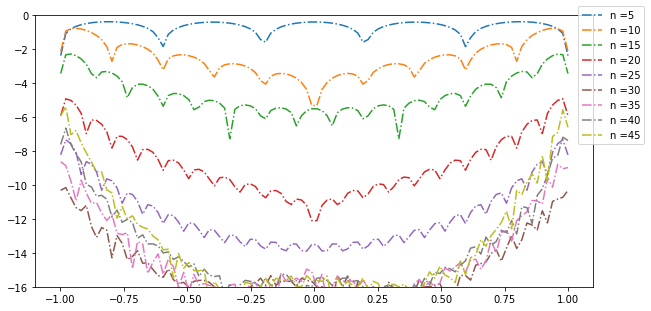

In [129]:
nn = np.arange(5,50,5);
barylagrange_interp_logerror(f1,nn);
plt.ylim([-16,0]);